# Visualizing Operations with Dask Dataframes on Fiscal Data

This post includes code from [Scalable-Data-Analysis-in-Python-with-Dask](https://github.com/PacktPublishing/-Scalable-Data-Analysis-in-Python-with-Dask/tree/master/Section%202) and [coiled-examples](https://github.com/coiled/coiled-examples).

In [1]:
import numpy as np
import dask.array as da
import pandas as pd
import sqlalchemy as db
from sqlalchemy import create_engine
import sqlite3
import pandas as pd

In [2]:
engine = db.create_engine("sqlite:///fiscal_data.db")
connection = engine.connect()
metadata = db.MetaData()

In [3]:
engine.execute("SELECT * FROM fiscal_data LIMIT 1").fetchall()

[(1996, 'East China', 'Anhui', '2093.3', 50661, 631930, 147002)]

In [4]:
sql = """
SELECT year
, region
, province
, gdp
, fdi
, it
, specific
FROM fiscal_data
"""

cnxn = connection

In [5]:
df = pd.read_sql(sql, cnxn)

In [6]:
df

year      region  province       gdp      fdi       it   specific
0    1996  East China     Anhui    2093.3    50661   631930   147002.0
1    1997  East China     Anhui   2347.32    43443   657860   151981.0
2    1998  East China     Anhui   2542.96    27673   889463   174930.0
3    1999  East China     Anhui   2712.34    26131  1227364   285324.0
4    2000  East China     Anhui   2902.09    31847  1499110   195580.0
..    ...         ...       ...       ...      ...      ...        ...
355  2003  East China  Zhejiang   9705.02   498055  2261631   391292.0
356  2004  East China  Zhejiang   11648.7   668128  3162299   656175.0
357  2005  East China  Zhejiang  13417.68   772000  2370200   656175.0
358  2006  East China  Zhejiang  15718.47   888935  2553268  1017303.0
359  2007  East China  Zhejiang  18753.73  1036576  2939778   844647.0

[360 rows x 7 columns]

In [7]:
df.columns

Index(['year', 'region', 'province', 'gdp', 'fdi', 'it', 'specific'], dtype='object')

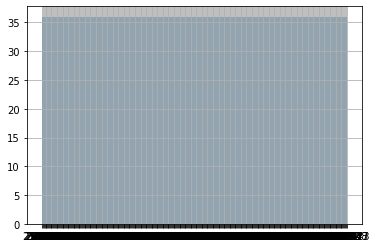

In [8]:
df.gdp.hist()

In [9]:
from dask.distributed import Client

client = Client(processes=False, threads_per_worker=2,
                n_workers=3, memory_limit='4GB')
client

<Client: 'inproc://192.168.1.71/5995/1' processes=3 threads=6, memory=12.00 GB>

In [10]:
from dask import dataframe as dd 

In [11]:
ddf = dd.from_pandas(df, npartitions=5)

In [12]:
print(ddf)

Dask DataFrame Structure:
                year  region province     gdp    fdi     it specific
npartitions=5                                                       
0              int64  object   object  object  int64  int64  float64
72               ...     ...      ...     ...    ...    ...      ...
...              ...     ...      ...     ...    ...    ...      ...
288              ...     ...      ...     ...    ...    ...      ...
359              ...     ...      ...     ...    ...    ...      ...
Dask Name: from_pandas, 5 tasks


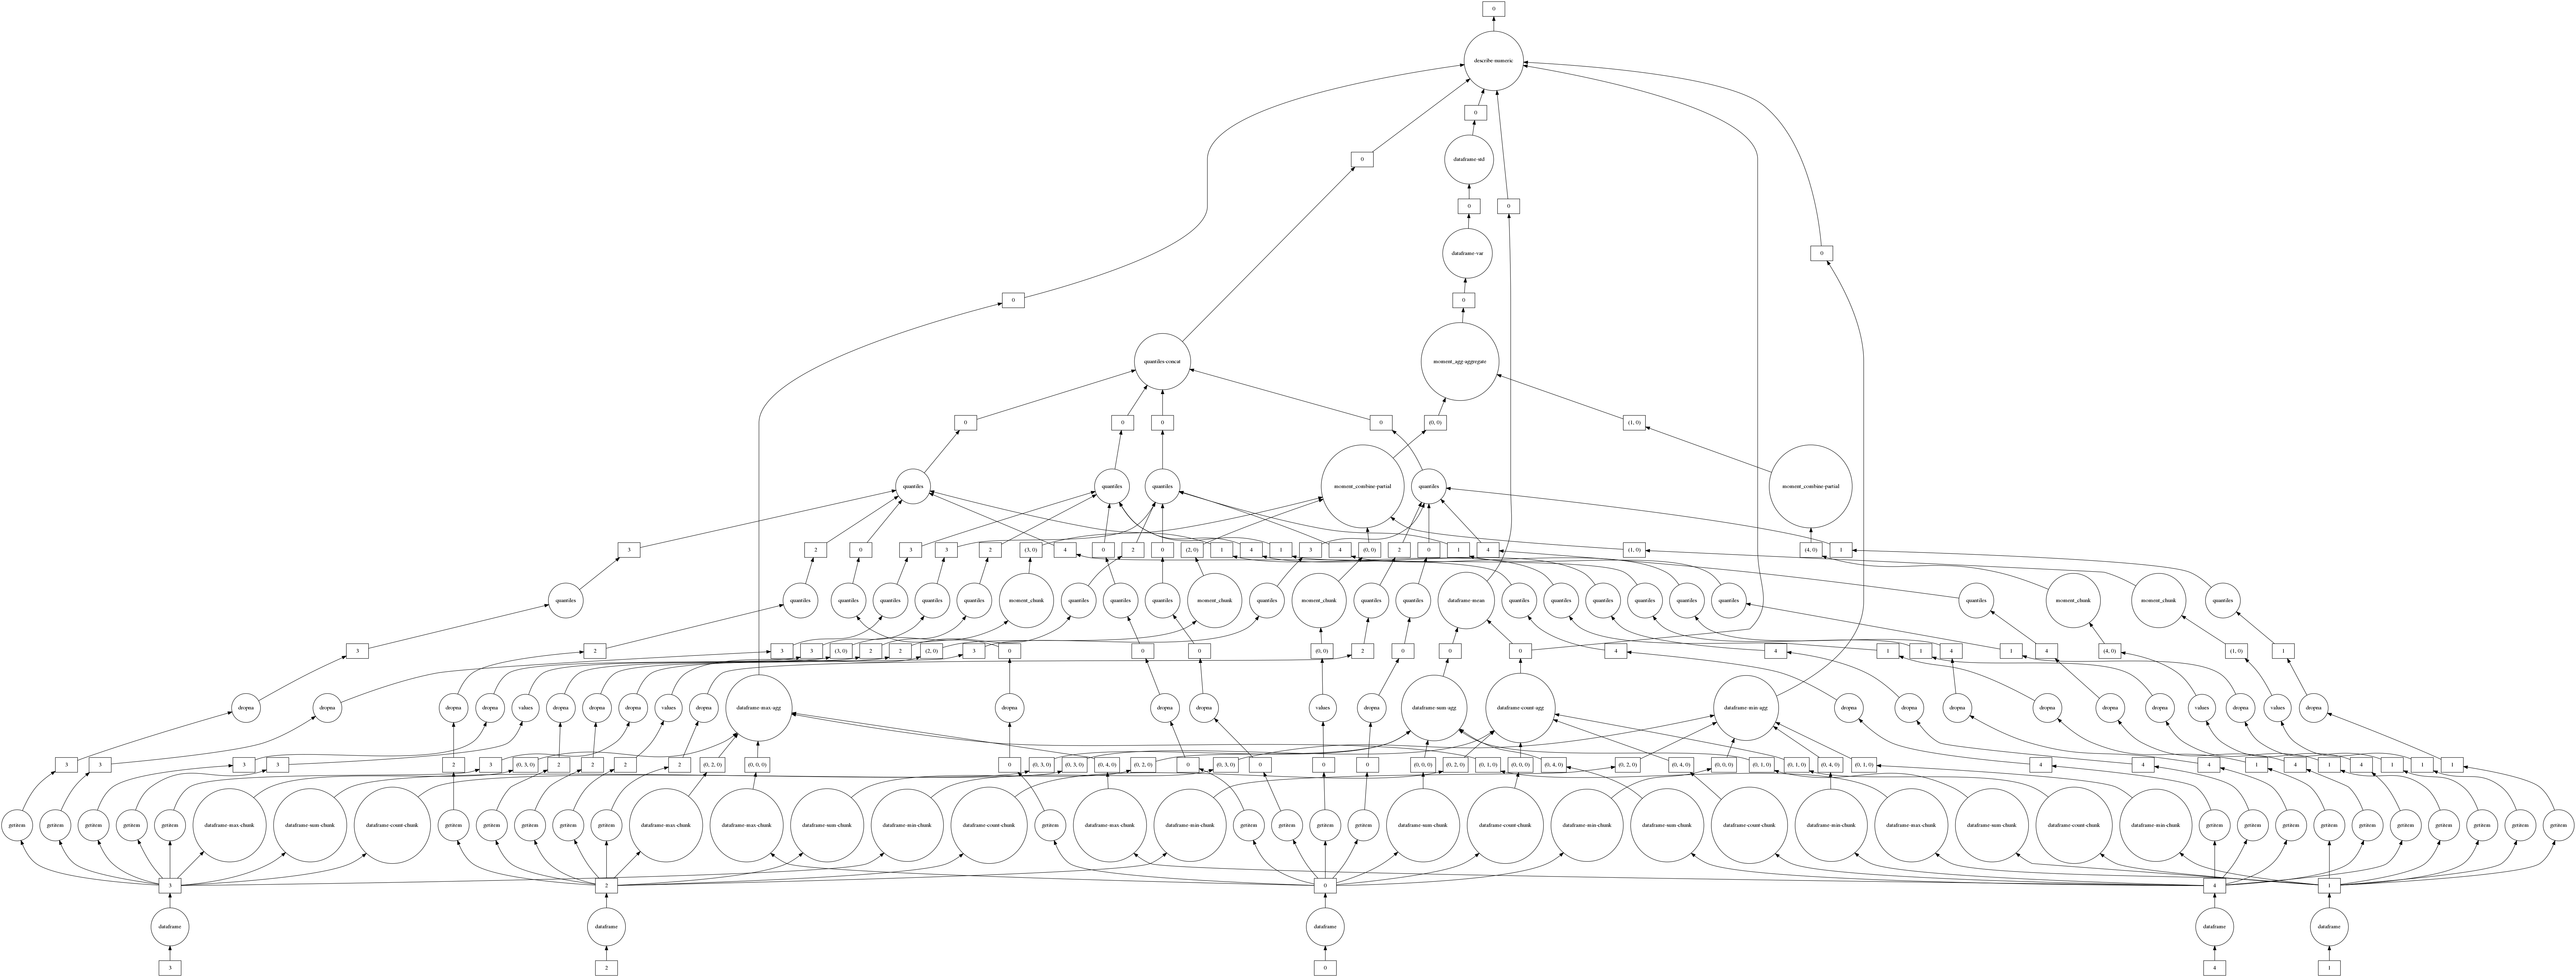

In [13]:
ddf.describe().visualize(filename='describe.png')

In [14]:
ddf.head()

year      region province      gdp    fdi       it  specific
0  1996  East China    Anhui   2093.3  50661   631930  147002.0
1  1997  East China    Anhui  2347.32  43443   657860  151981.0
2  1998  East China    Anhui  2542.96  27673   889463  174930.0
3  1999  East China    Anhui  2712.34  26131  1227364  285324.0
4  2000  East China    Anhui  2902.09  31847  1499110  195580.0

In [15]:
max_gdp_per_region = ddf.groupby('region')['gdp'].max()

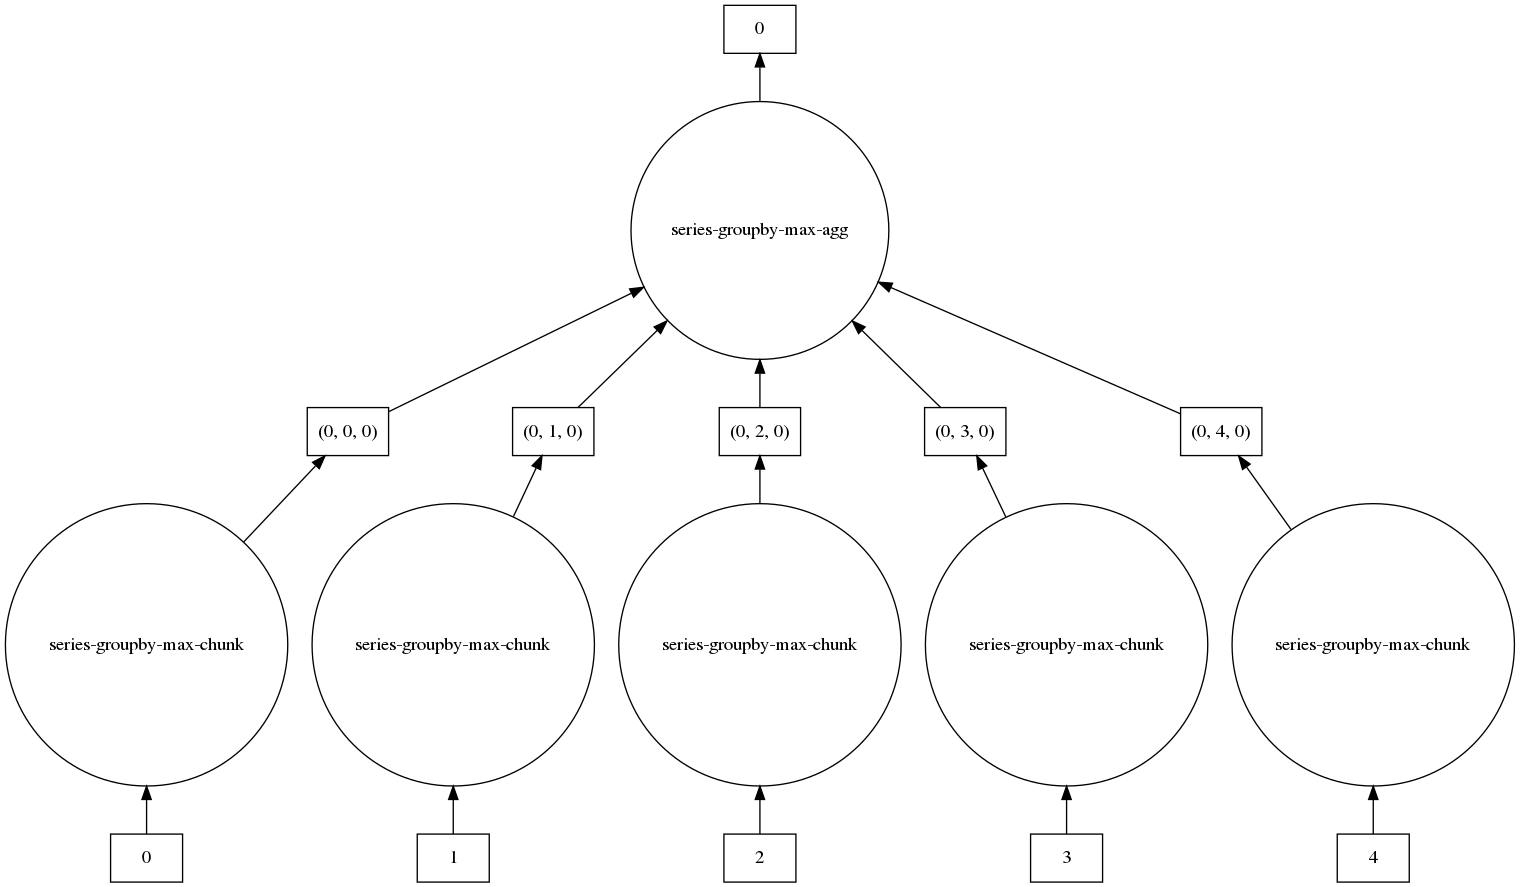

In [16]:
max_gdp_per_region.visualize()

In [17]:
max_gdp_per_region.compute()

region
East China             9705.02
North China            9846.81
Northwest China         956.32
South Central China     9439.6
Southwest China          937.5
Northeast China        9304.52
Name: gdp, dtype: object

In [18]:
ddf

Dask DataFrame Structure:
                year  region province     gdp    fdi     it specific
npartitions=5                                                       
0              int64  object   object  object  int64  int64  float64
72               ...     ...      ...     ...    ...    ...      ...
...              ...     ...      ...     ...    ...    ...      ...
288              ...     ...      ...     ...    ...    ...      ...
359              ...     ...      ...     ...    ...    ...      ...
Dask Name: from_pandas, 5 tasks

In [19]:
ddf.npartitions

5

In [20]:
ddf.npartitions

5

In [21]:
len(ddf)

360

In [22]:
from dask.distributed import Client

client = Client(processes=False, threads_per_worker=2, n_workers=3, memory_limit="4GB")
client

/home/gao/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39701 instead
  http_address["port"], self.http_server.port


<Client: 'inproc://192.168.1.71/5995/20' processes=3 threads=6, memory=12.00 GB>

In [23]:
client.id

'Client-9f9a71c2-0c90-11eb-976b-cff3b7a8059e'

In [24]:
ddf.describe().compute()

year           fdi            it      specific
count   360.000000  3.600000e+02  3.600000e+02  3.560000e+02
mean   2001.500000  1.961394e+05  2.165819e+06  5.834707e+05
std       3.456857  3.030440e+05  1.769294e+06  6.540553e+05
min    1996.000000  2.000000e+00  1.478970e+05  8.964000e+03
25%    1998.750000  3.309900e+04  1.077466e+06  2.237530e+05
50%    2001.500000  1.411025e+05  2.020634e+06  4.243700e+05
75%    2004.250000  4.065125e+05  3.375492e+06  1.011846e+06
max    2007.000000  1.743140e+06  1.053331e+07  3.937966e+06

In [25]:
ddf.columns

Index(['year', 'region', 'province', 'gdp', 'fdi', 'it', 'specific'], dtype='object')

In [27]:
ddf["year"] = ddf["year"].astype(int)
ddf["fdi"] = ddf["fdi"].astype(float)
# ddf["province"] = ddf["province"].astype(float)
# ddf["region"] = ddf["region"].astype(float)
ddf["gdp"] = ddf["gdp"].astype(float)
ddf["it"] = ddf["it"].astype(float)

In [28]:
ddf

Dask DataFrame Structure:
                year  region province      gdp      fdi       it specific
npartitions=5                                                            
0              int64  object   object  float64  float64  float64  float64
72               ...     ...      ...      ...      ...      ...      ...
...              ...     ...      ...      ...      ...      ...      ...
288              ...     ...      ...      ...      ...      ...      ...
359              ...     ...      ...      ...      ...      ...      ...
Dask Name: assign, 65 tasks

In [29]:
ddf.nlargest(20, 'gdp').compute()

year               region   province       gdp        fdi          it  \
71   2007  South Central China  Guangdong  31777.01  1712603.0   4947824.0   
70   2006  South Central China  Guangdong  26587.76  1451065.0   4559252.0   
263  2007           East China   Shandong  25776.91  1101159.0   6357869.0   
69   2005  South Central China  Guangdong  22557.37  1236400.0   4327217.0   
262  2006           East China   Shandong  21900.19  1000069.0   5304833.0   
179  2007           East China    Jiangsu  21742.05  1743140.0   3557071.0   
68   2004  South Central China  Guangdong  18864.62  1001158.0   5193902.0   
359  2007           East China   Zhejiang  18753.73  1036576.0   2939778.0   
178  2006           East China    Jiangsu  18598.69  1318339.0   2926542.0   
261  2005           East China   Shandong  18366.87   897000.0   4142859.0   
67   2003  South Central China  Guangdong  15844.64   782294.0   4073606.0   
358  2006           East China   Zhejiang  15718.47   888935.0   2553268.0   
260  2004           East China   Shandong  15021.84   870064.0   3732990.0   
143  2007  South Central China      Henan  15012.46   306162.0  10533312.0   
177  2005           East China    Jiangsu  15003.60  1213800.0   3479548.0   
119  2007          North China      Hebei  13607.32   241621.0   7537692.0   
66   2002  South Central China  Guangdong  13502.42  1133400.0   3545004.0   
357  2005           East China   Zhejiang  13417.68   772000.0   2370200.0   
275  2007           East China   Shanghai  12494.01   792000.0   2386339.0   
176  2004           East China    Jiangsu  12442.87  1056365.0   2410257.0   

      specific  
71    859482.0  
70   1897575.0  
263  2121243.0  
69   1491588.0  
262  1204547.0  
179  1188989.0  
68   1491588.0  
359   844647.0  
178  1388043.0  
261  1011203.0  
67   1550764.0  
358  1017303.0  
260  1011203.0  
143  3860764.0  
177  1483371.0  
119  2981235.0  
66   1235386.0  
357   656175.0  
275   272744.0  
176  1483371.0

In [30]:
without_ec = ddf[ddf.region !='East China']

In [31]:
without_ec.nlargest(20, 'gdp').compute()

year               region   province       gdp        fdi          it  \
71   2007  South Central China  Guangdong  31777.01  1712603.0   4947824.0   
70   2006  South Central China  Guangdong  26587.76  1451065.0   4559252.0   
69   2005  South Central China  Guangdong  22557.37  1236400.0   4327217.0   
68   2004  South Central China  Guangdong  18864.62  1001158.0   5193902.0   
67   2003  South Central China  Guangdong  15844.64   782294.0   4073606.0   
143  2007  South Central China      Henan  15012.46   306162.0  10533312.0   
119  2007          North China      Hebei  13607.32   241621.0   7537692.0   
66   2002  South Central China  Guangdong  13502.42  1133400.0   3545004.0   
142  2006  South Central China      Henan  12362.79   184526.0   7601825.0   
65   2001  South Central China  Guangdong  12039.25  1193203.0   2152243.0   
118  2006          North China      Hebei  11467.60   201434.0   5831974.0   
64   2000  South Central China  Guangdong  10741.25  1128091.0   1927102.0   
141  2005  South Central China      Henan  10587.42   123000.0   5676863.0   
299  2007      Southwest China    Sichuan  10562.39   149322.0  10384846.0   
117  2005          North China      Hebei  10012.11   191000.0   4503640.0   
23   2007          North China    Beijing   9846.81   506572.0   1962192.0   
167  2007  South Central China      Hunan   9439.60   327051.0   8340692.0   
155  2007  South Central China      Hubei   9333.40   276622.0   7666512.0   
215  2007      Northeast China   Liaoning   9304.52   598554.0   5502192.0   
63   1999  South Central China  Guangdong   9250.68  1165750.0   1789235.0   

      specific  
71    859482.0  
70   1897575.0  
69   1491588.0  
68   1491588.0  
67   1550764.0  
143  3860764.0  
119  2981235.0  
66   1235386.0  
142  2018158.0  
65   1257232.0  
118  1253141.0  
64    714572.0  
141  1171796.0  
299  3937966.0  
117   859056.0  
23    752279.0  
167  3156087.0  
155  2922784.0  
215  3396397.0  
63    988521.0

In [32]:
ddf['province'].compute()

0         Anhui
1         Anhui
2         Anhui
3         Anhui
4         Anhui
         ...   
355    Zhejiang
356    Zhejiang
357    Zhejiang
358    Zhejiang
359    Zhejiang
Name: province, Length: 360, dtype: object

In [33]:
ddf.where(ddf['province']=='Zhejiang').compute()

year      region  province       gdp        fdi         it   specific
0       NaN         NaN       NaN       NaN        NaN        NaN        NaN
1       NaN         NaN       NaN       NaN        NaN        NaN        NaN
2       NaN         NaN       NaN       NaN        NaN        NaN        NaN
3       NaN         NaN       NaN       NaN        NaN        NaN        NaN
4       NaN         NaN       NaN       NaN        NaN        NaN        NaN
..      ...         ...       ...       ...        ...        ...        ...
355  2003.0  East China  Zhejiang   9705.02   498055.0  2261631.0   391292.0
356  2004.0  East China  Zhejiang  11648.70   668128.0  3162299.0   656175.0
357  2005.0  East China  Zhejiang  13417.68   772000.0  2370200.0   656175.0
358  2006.0  East China  Zhejiang  15718.47   888935.0  2553268.0  1017303.0
359  2007.0  East China  Zhejiang  18753.73  1036576.0  2939778.0   844647.0

[360 rows x 7 columns]

In [34]:
mask_after_2010 = ddf.where(ddf['year']>2000)

In [35]:
mask_after_2010.compute()

year      region  province       gdp        fdi         it   specific
0       NaN         NaN       NaN       NaN        NaN        NaN        NaN
1       NaN         NaN       NaN       NaN        NaN        NaN        NaN
2       NaN         NaN       NaN       NaN        NaN        NaN        NaN
3       NaN         NaN       NaN       NaN        NaN        NaN        NaN
4       NaN         NaN       NaN       NaN        NaN        NaN        NaN
..      ...         ...       ...       ...        ...        ...        ...
355  2003.0  East China  Zhejiang   9705.02   498055.0  2261631.0   391292.0
356  2004.0  East China  Zhejiang  11648.70   668128.0  3162299.0   656175.0
357  2005.0  East China  Zhejiang  13417.68   772000.0  2370200.0   656175.0
358  2006.0  East China  Zhejiang  15718.47   888935.0  2553268.0  1017303.0
359  2007.0  East China  Zhejiang  18753.73  1036576.0  2939778.0   844647.0

[360 rows x 7 columns]

In [36]:
def add_some_text(cname, *args, **kwargs):
    return "Region name is " + cname

dummy_values = ddf['region'].apply(add_some_text, axis=1)

/home/gao/anaconda3/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('region', 'object'))

  warnings.warn(meta_warning(meta))


In [37]:
dummy_values

Dask Series Structure:
npartitions=5
0      object
72        ...
        ...  
288       ...
359       ...
Name: region, dtype: object
Dask Name: apply, 75 tasks

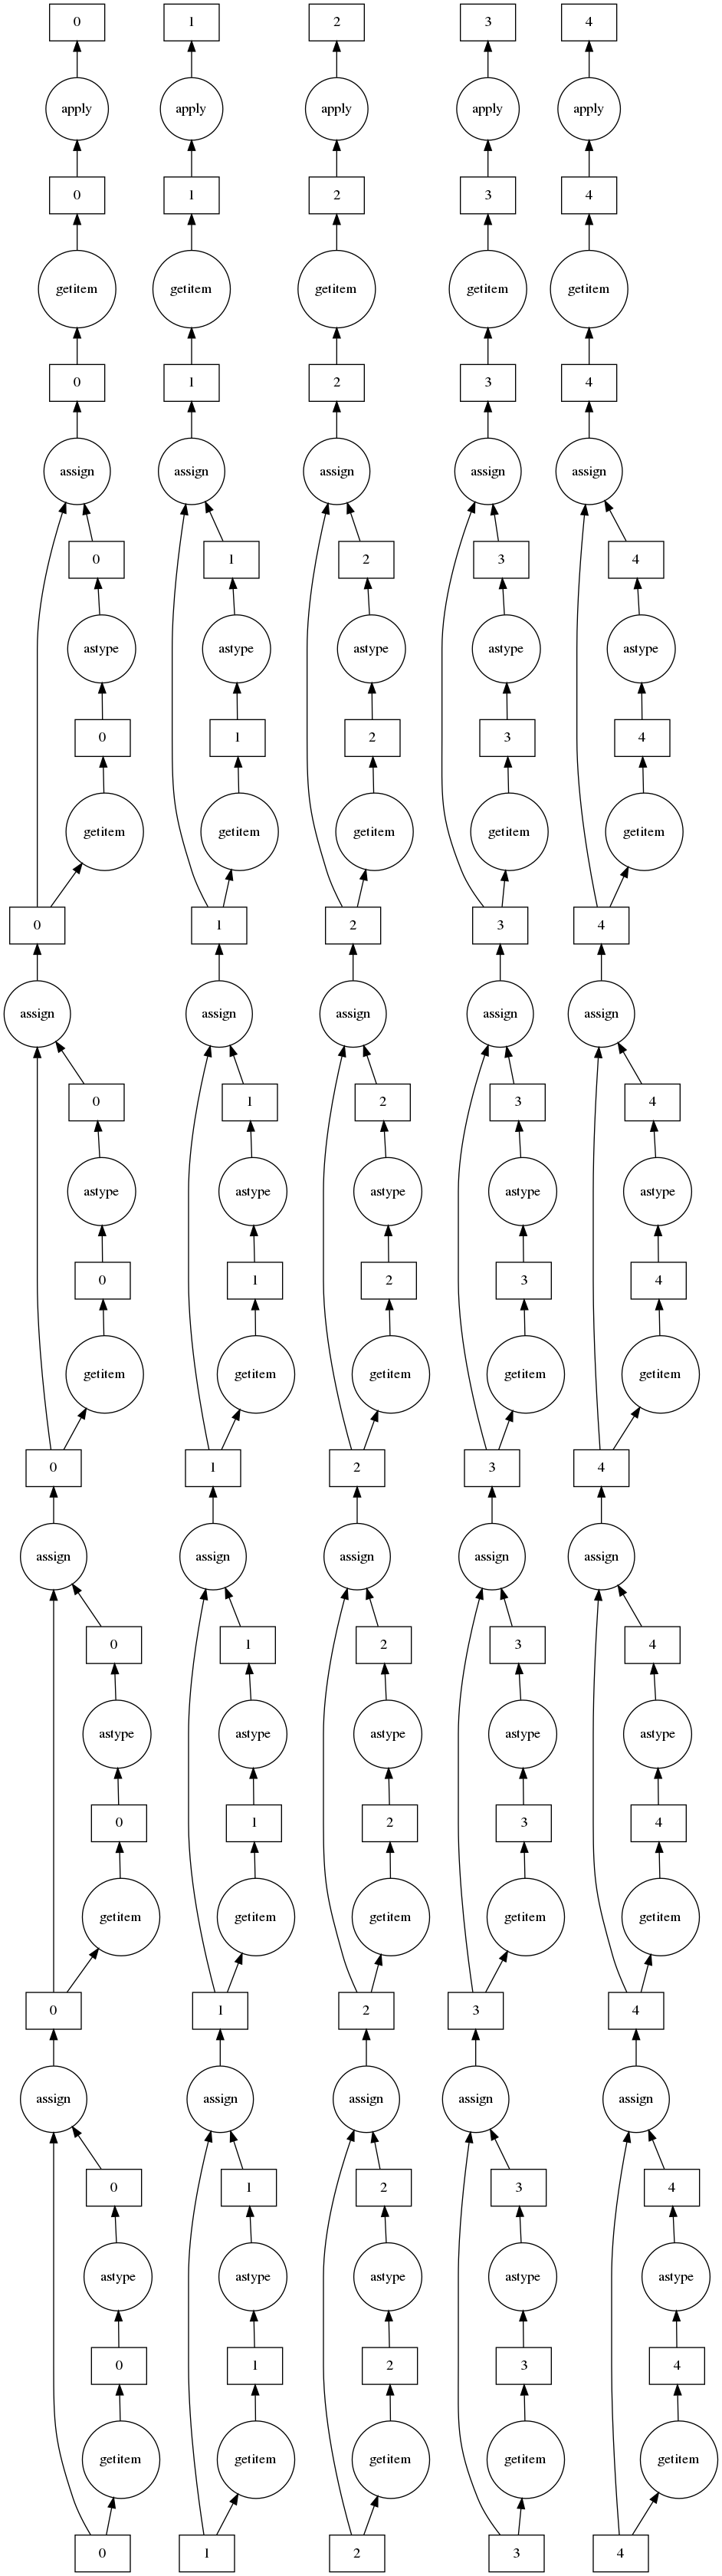

In [38]:
dummy_values.visualize()

In [39]:
dummy_values.compute()

0      Region name is East China
1      Region name is East China
2      Region name is East China
3      Region name is East China
4      Region name is East China
                 ...            
355    Region name is East China
356    Region name is East China
357    Region name is East China
358    Region name is East China
359    Region name is East China
Name: region, Length: 360, dtype: object

In [40]:
max_per_region_yr = ddf.groupby('region').apply(lambda x: x.loc[x['gdp'].idxmax(), 'year'])

/home/gao/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


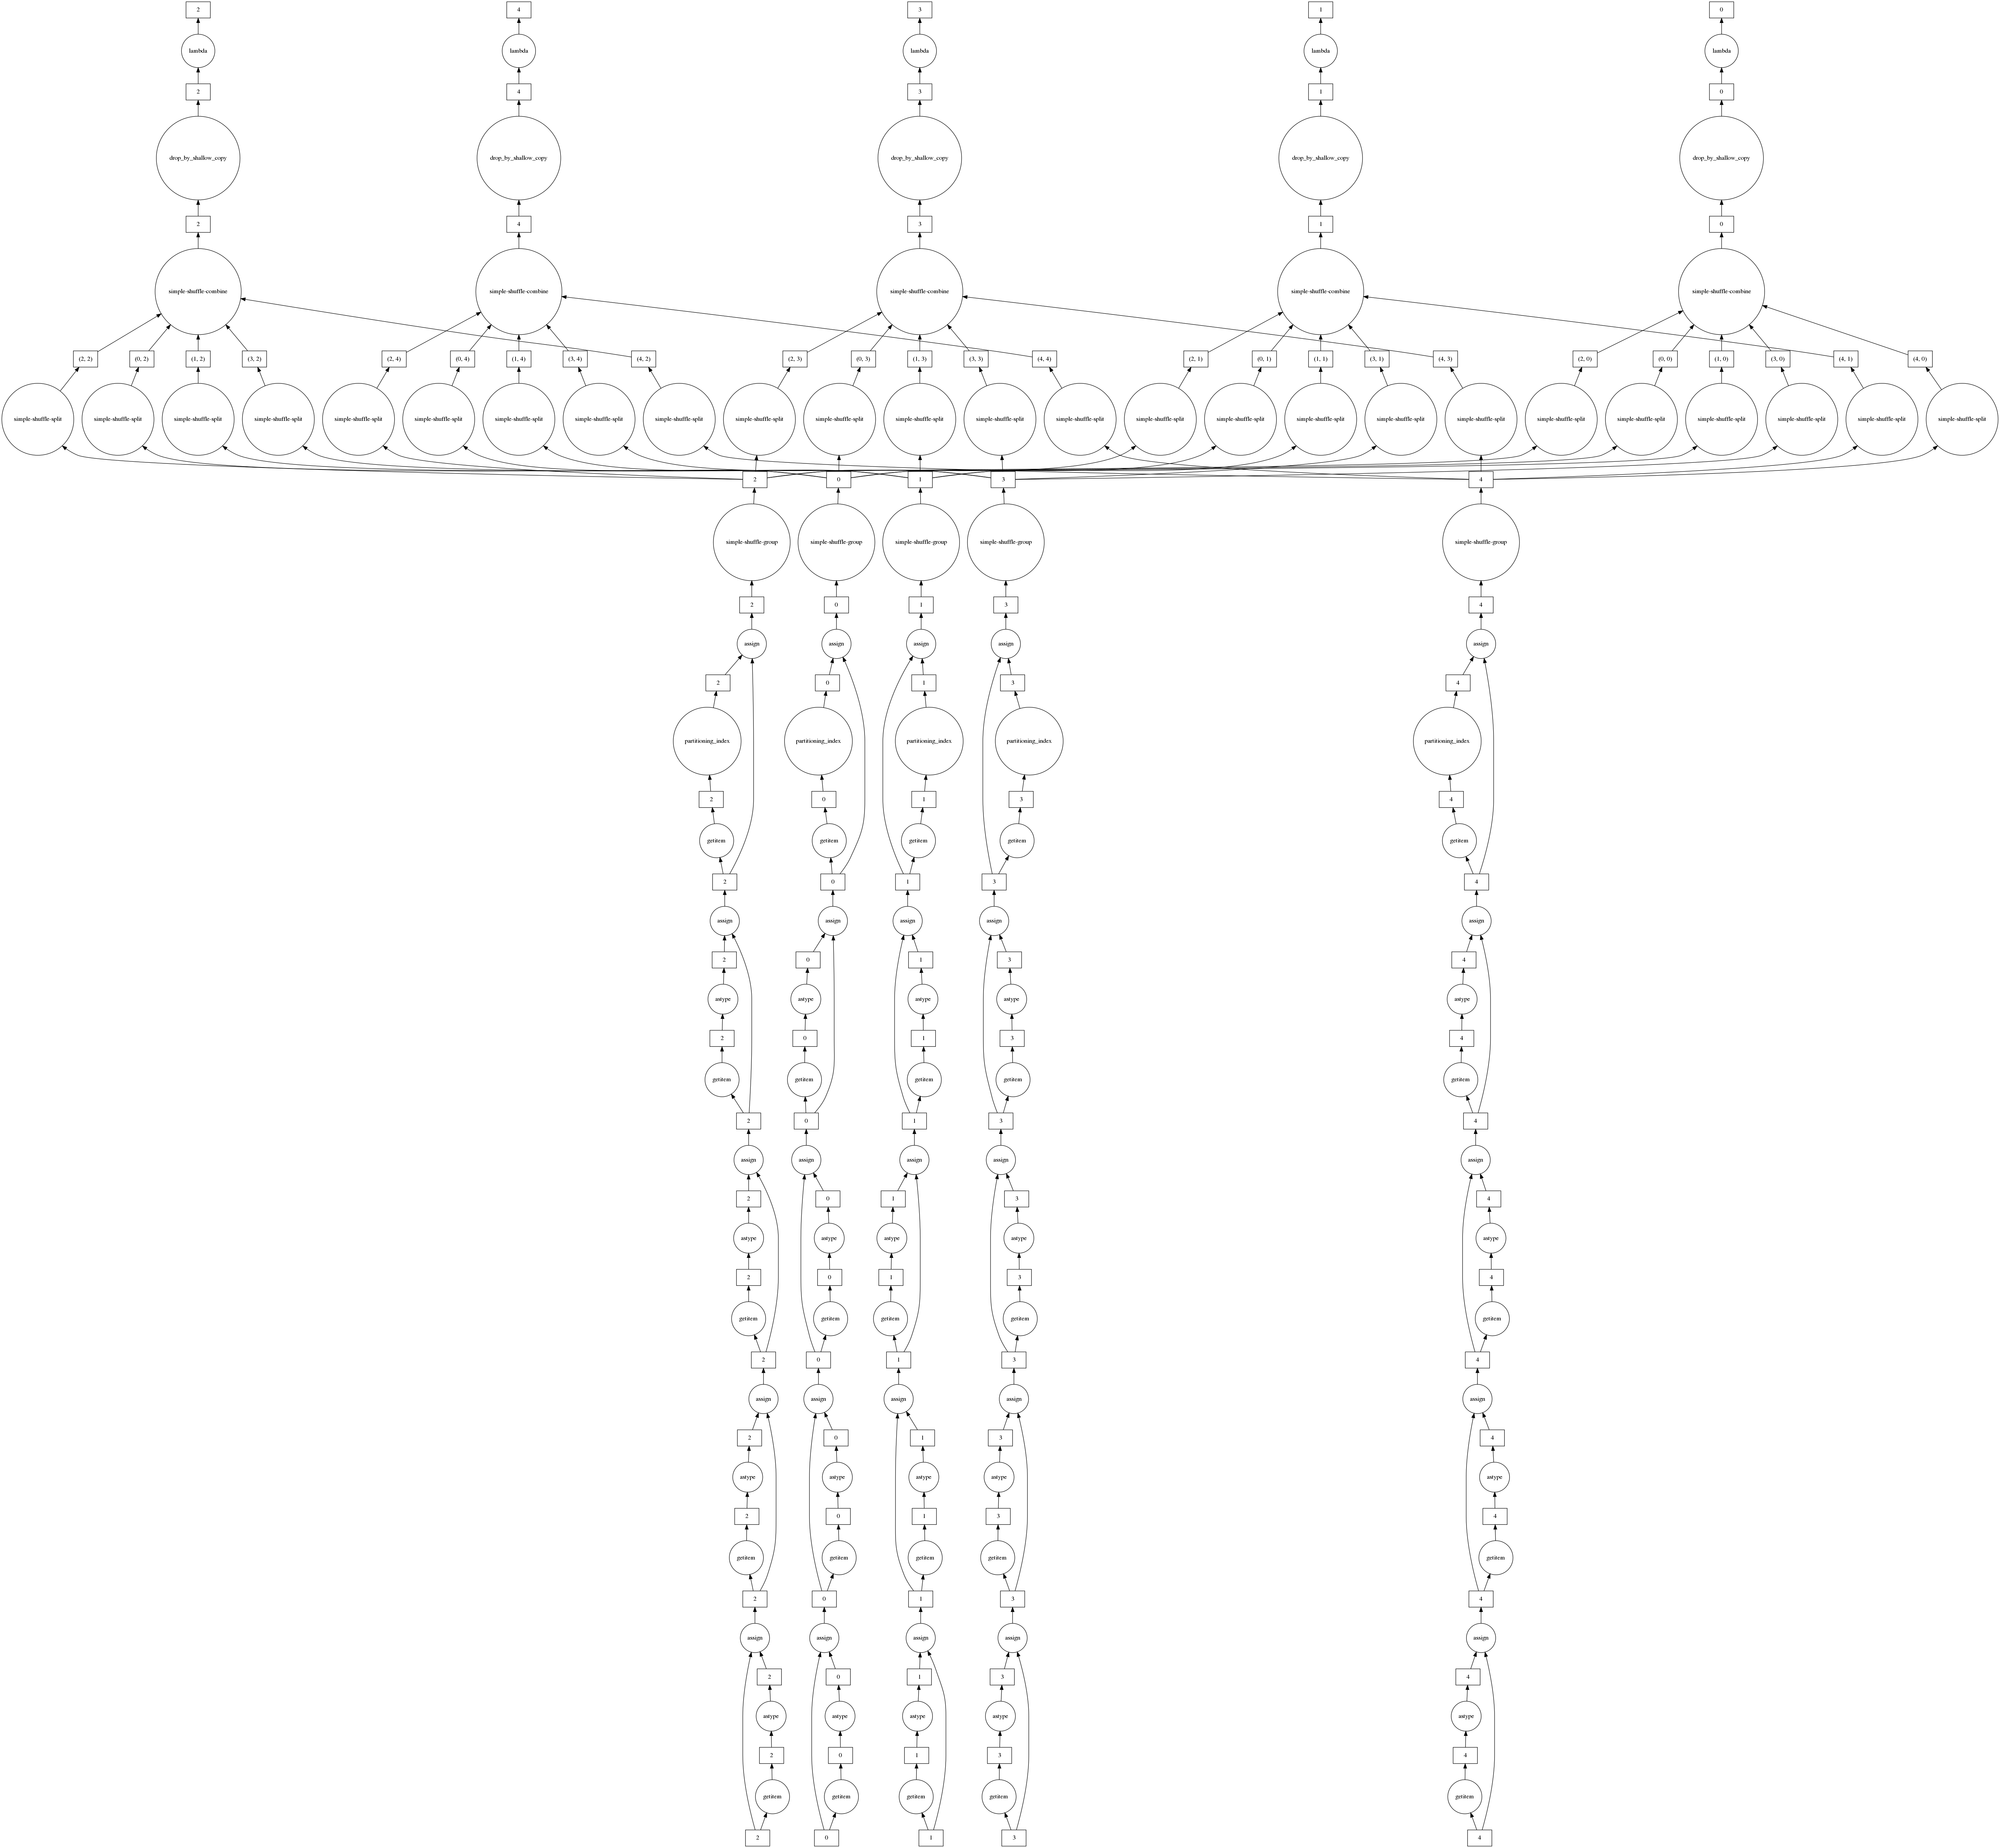

In [41]:
max_per_region_yr.visualize()

In [42]:
max_per_region_yr.compute()

region
North China            2007
Northeast China        2007
Northwest China        2007
South Central China    2007
East China             2007
Southwest China        2007
dtype: int64